## Alumnos: Pablo Torre e Ignacio Jiménez

### Manual

In [1]:
#prueba lunar lander por humano

# import gymnasium as gym

# env = gym.make("LunarLander-v2", render_mode="rgb_array")

# import numpy as np
# import pygame
# import gymnasium.utils.play

# lunar_lander_keys = {
#     (pygame.K_UP,): 2,
#     (pygame.K_LEFT,): 1,
#     (pygame.K_RIGHT,): 3,
# }
# gymnasium.utils.play.play(env, zoom=3, keys_to_action=lunar_lander_keys, noop=0)

# Neuroevolución

### Funciones

In [2]:
# neuroevolución
import numpy as np
from MLP import MLP

# construir modelo
LAYERS = [8, 6, 4]
model =  MLP(LAYERS)
MLP.to_chromosome(model)

# pasar al modelo los pesos del mejor cromosoma obtenido con neuroevolución

# definir política
def policy (ind, observation):
    model.from_chromosome(ind)
    s = model.forward(observation)
    action = np.argmax(s)
    return action

In [7]:
# prueba lunar lander por agente
import gymnasium as gym
import ast

env = gym.make("LunarLander-v2", render_mode=None)

# definir función de fitness
def run (ind):
    #observation, info = env.reset(seed=42)
    racum = 0
    # repite 10 veces y devuelve la media de las recompensas
    for _ in range(10):
        observation, _ = env.reset()
        while True:
            action = policy(ind, observation)
            observation, reward, terminated, truncated, info = env.step(action)
            racum += reward
            if terminated or truncated:
                break
    return racum/10

In [4]:
# Define operadores de números reales
import random
import copy
import matplotlib.pyplot as plt
from IPython.display import clear_output


def create (N=50): # crea y devuelve población
    return [MLP(LAYERS).to_chromosome() for _ in range(N)]

def crossover (ind1, ind2, pcross): # devuelve el cruce (emparejamiento) de dos individuos
    if pcross < random.random():
        return (ind1, ind2)

    # se aplica cruce aritmético
    for i in range(len(ind1)):
        beta = random.random()
        ind1[i] = beta*ind1[i] + (1-beta)*ind2[i]
        ind2[i] = beta*ind2[i] + (1-beta)*ind1[i]
        
    return (ind1, ind2)

def mutate (ind, pmut1, pmut2, gen, ngen): # devuelve individuo mutado;
    # pmut1 es la probabilidad de mutar un individuo
    # pmut2 es la probabilidad de mutar un gen
    if pmut1 < random.random():
        return ind
    # get an np array of 100 numbers between 1 and 0.1
    e = np.linspace(0.7, 1, num=ngen) # para ir reduciendo el tamaño de la mutación
    for i in range(len(ind)):
        if pmut2 < random.random():
            continue
        ind[i] += random.uniform(-1, 1)/e[gen]
        # clip to -5 and 5
        ind[i] = np.clip(ind[i], -5, 5)
    return ind

In [5]:
def sort_pop(pop, fit):
    # Pair each individual with its fitness value
    paired_pop_fit = [(individual, fit(individual)) for individual in pop]
    # Sort the pairs based on fitness value
    sorted_pop_fit = sorted(paired_pop_fit, key=lambda x: x[1])
    # Unpack the sorted pairs into separate lists
    sorted_pop, sorted_fit = map(list, zip(*sorted_pop_fit))
    return sorted_pop, sorted_fit

def select (pop, T): # devuelve un individuo seleccionado por torneo, devuelve una copia para evitar efectos laterales
    index_list = [random.randrange(len(pop)) for _ in range(T)]
    return copy.deepcopy(pop[min(index_list)])

track_fitness = []
track_avg_fitness = []
def evolve (pop, fit, pmut1, pmut2, pcross=0.7, ngen=100, T=2, trace=0, elitism=False, maximize=False):
    # devuelve la población evolucionada
    # si trace > 0, muestra información cada trace generaciones
    # si elitism=True, se aplica elitismo
    # si maximize=True, se busca el máximo en lugar del mínimo
    best = None
    best_fit = None
    pop_size = len(pop)
    for gen in range(ngen):
        newpop = []
        for _ in range(pop_size//2):
            # seleccionamos dos individuos
            ind1 = select(pop, T)
            ind2 = select(pop, T)
            # los cruzamos
            hijo1, hijo2 = crossover(ind1, ind2, pcross)
            # los mutamos
            hijo1 = mutate(hijo1, pmut1, pmut2, gen, ngen)
            hijo2 = mutate(hijo2, pmut1, pmut2, gen, ngen)
            # los añadimos a la nueva población
            newpop.append(hijo1)
            newpop.append(hijo2)
        # elitismo
        if elitism and best != None:
            # eliminamos un individuo aleatorio
            newpop.pop(random.randrange(len(newpop)))
            # añadimos el mejor de la generación anterior
            newpop.append(best)

        # evaluamos la nueva población
        pop, fit_pop = sort_pop(newpop, fit)
        if maximize:
            pop.reverse()
            fit_pop.reverse()
        # nos quedamos con el mejor
        if maximize:
            if best_fit == None or fit_pop[0] > best_fit:
                best = pop[0]
                best_fit = fit_pop[0]
        else:
            if best_fit == None or fit_pop[0] < best_fit:
                best = pop[0]
                best_fit = fit_pop[0]
        # mostramos información
        if gen % trace == 0:
            clear_output()
            print("Generación: ", gen)
            print("Población: ", len(pop))
            if maximize: 
                print("Reward: ", np.max(fit_pop))
                track_fitness.append(np.max(fit_pop))
                track_avg_fitness.append(np.mean(fit_pop))
            else: 
                print("Reward: ", np.min(fit_pop))
                track_fitness.append(np.min(fit_pop))
                track_avg_fitness.append(np.mean(fit_pop))
            # plot moving average
            ma_zize = 10
            if len(track_fitness) > 5:
                plt.plot(track_fitness)
                plt.plot(np.convolve(track_fitness, np.ones(ma_zize)/ma_zize, mode='valid'))
                plt.show()
                plt.plot(np.convolve(track_avg_fitness, np.ones(ma_zize)/ma_zize, mode='valid'))
                plt.show()

    return pop

### Entrenamiento

Generación:  411
Población:  100
Reward:  290.39283008797383


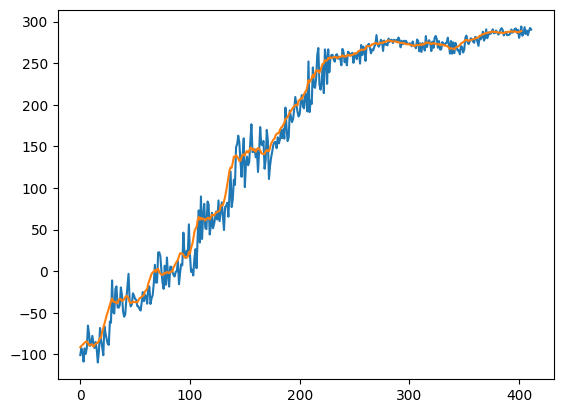

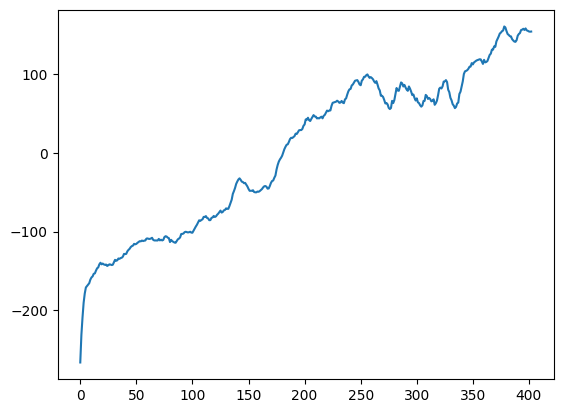

In [16]:
pop = create(N=100)
pop = evolve(pop, run, pmut1=0.4, pmut2=60/82, pcross=0.0, ngen=500, T=2, trace=1, maximize=True, elitism=True)

### Guardar resultados y evaluar

In [ ]:
# save list pop to file
with open('pop.txt', 'w') as f:
    for item in pop:
        f.write("%s\n" % item)

In [6]:
# load list pop from file
with open('pop.txt', 'r') as f:
    pop = f.readlines()
    pop = [ast.literal_eval(ind) for ind in pop]

In [8]:
# evaluar la población
fitness = []
for ind in pop:
    fitness.append(run(ind))

In [11]:
print("Mejor individuo: ", np.max(fitness))
print(np.argmax(fitness))

Mejor individuo:  262.91991259450896
5


In [15]:
import gymnasium as gym
import ast

env = gym.make("LunarLander-v2", render_mode=None)

# definir función de fitness
def run_eval (ind):
    #observation, info = env.reset(seed=42)
    racum = []
    # repite 10 veces y devuelve la media de las recompensas
    for _ in range(100):
        observation, _ = env.reset()
        r = 0
        while True:
            action = policy(ind, observation)
            observation, reward, terminated, truncated, info = env.step(action)
            r += reward
            if terminated or truncated:
                break
        racum.append(r)
    return racum

In [16]:
l = run_eval(pop[5])

In [18]:
mean = np.mean(l)
std = np.std(l)
success_rate = len([x for x in l if x > 200])/len(l)
print(mean, std, success_rate)

260.31719832492615 64.35246236724318 0.92


### Conclusiones

Debido a las múltiples pruebas realizadas, hemos podido comprobar lo predominantemente aleatorio que es este experimento. Tanto es así, que en nuestra experiencia, casi es igual de eficiente probar números aleatorios hasta encontrar una combinación de 82 parámetros que funcione bien. Hemos llegado a esta conclusión viendo lo impredecible que resulta la evolución del fitness del modelo, que puede quedarse estancada mucho tiempo para de repente pegar saltos de 100 puntos de la nada, y que varía drásticamente de una ejecución de entreamiento a otra. También porque solo hemos conseguido obtener buenos resultados con mutaciones muy extremas, lo que sugiere que hay poca posibilidad de avanzar gradualmente. Este algoritmo difícilmente funcionará en problemas más complejos.

# DeepQN

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gymnasium as gym
import numpy as np

env = gym.make("LunarLander-v2", render_mode=None)


if torch.cuda.is_available():
    device = torch.device("cuda")
    print('Using GPU')
else:
    device = torch.device("cpu")
    print('Using CPU')

Using GPU


### Modelos

In [39]:
class DQN(torch.nn.Module):
    """Perceptron multicapa de 2 capas de 32 y una se salida"""
    def __init__(self):
        super(DQN, self).__init__()
        self.dense1 = nn.Linear(8, 32)
        self.dense2 = nn.Linear(32, 32)
        self.dense3 = nn.Linear(32, 4)

    def forward(self, x):
        """Construcción de las capas"""
        x = self.dense1(x)
        x = F.relu(x)
        x = self.dense2(x)
        x = F.relu(x)
        x = self.dense3(x)
        return x

main_nn = DQN().to(device) # Red principal
target_nn = DQN().to(device) # Red objetivo
# Copiamos los pesos de la red principal a la red objetivo
target_nn.load_state_dict(main_nn.state_dict())
# no grad for target_nn
for param in target_nn.parameters():
    param.requires_grad = False

optimizer = optim.AdamW(main_nn.parameters(), lr=1e-4) # Optimizador Adam
mse = nn.MSELoss()

### Funciones

In [40]:
from collections import deque

class ReplayBuffer(object):
    """Experience replay buffer that samples uniformly."""
    def __init__(self, size):
        self.buffer = deque(maxlen=size)

    def add(self, state, action, reward, next_state, done):
        if len(state) != 8:
            print('--'*10)
            print(state) 
        self.buffer.append((state, action, reward, next_state, done))

    def __len__(self):
        return len(self.buffer)
    
    def sample(self, num_samples):
        states, actions, rewards, next_states, dones = [], [], [], [], []
        idx = np.random.choice(len(self.buffer), num_samples)
        for i in idx:
            elem = self.buffer[i]
            state, action, reward, next_state, done = elem
            states.append(np.array(state, copy=False))
            actions.append(np.array(action, copy=False))
            rewards.append(reward)
            next_states.append(np.array(next_state, copy=False))
            dones.append(done)
        states = np.array(states)
        actions = np.array(actions)
        rewards = np.array(rewards, dtype=np.float32)
        next_states = np.array(next_states)
        dones = np.array(dones, dtype=np.float32)
        return states, actions, rewards, next_states, dones

In [41]:
def select_epsilon_greedy_action(state, epsilon):
    with torch.no_grad():
        """Acción aleatoria con probabilidad menor que epsilon, en otro caso la mejor."""
        result = torch.rand(1).item()
        if result < epsilon:
            return env.action_space.sample() # Elegimos una acción aleatória
        else:
            return torch.argmax(main_nn(state.to(device))).detach().to('cpu').numpy() # Elección de acción Greedy.
    
 # Configuración de cada iteración de entrenamiento
def train_step(states, actions, rewards, next_states, dones, discount, num_actions):
    
    # Calculo de los objetivos (segunda red)
    next_qs = target_nn(torch.tensor(next_states).to(device))
    max_next_qs = torch.max(next_qs, dim=-1).values
    target = torch.tensor(rewards).to(device) + torch.tensor((1. - dones) * discount).to(device) * max_next_qs

    # Forward pass
    qs = main_nn(torch.tensor(states).to(device))
    action_masks = F.one_hot(torch.tensor(actions).to(device), num_actions)
    masked_qs = torch.sum(action_masks * qs, dim=-1)
    loss = mse(masked_qs, target)

    # Backward pass
    optimizer.zero_grad()  # Zero gradients
    loss.backward()        # Compute gradients
    optimizer.step()       # Update weights
    return loss

In [42]:
def train(num_episodes, batch_size, discount, epsilon):
    buffer = ReplayBuffer(100000)
    cur_frame = 0
    env = gym.make("LunarLander-v2", render_mode=None)

    # Comienzo del entrenamiento. Jugamos una vez y entrenamos con un batch.
    reward_list = []
    losses = []
    for episode in range(num_episodes+1):
        state = env.reset()[0] #reseteo del ecosistema
        ep_reward, done = 0, False
        num_steps = 0
        while not done:
            state_in = torch.tensor(state).unsqueeze(0)
            action = select_epsilon_greedy_action(state_in, epsilon)
            next_state, reward, done, _ = env.step(action)[:-1]
            num_steps += 1
            if num_steps > 2000: # Si el juego dura más de 2000 pasos, lo paramos.
                done = True
                ep_reward -= 0 # Penalizamos el juego largo.
            ep_reward += reward
            # Guardamos el juego.
            buffer.add(state, action, reward, next_state, done)
            state = next_state
            cur_frame += 1
            # Copiamos los pesos de main_nn a target_nn.
            if cur_frame % 2000 == 0:
                target_nn.load_state_dict(main_nn.state_dict())
            # Entrenamiento de la red neuronal.
            if len(buffer) >= batch_size:
                states, actions, rewards, next_states, dones = buffer.sample(batch_size)
                loss = train_step(states, actions, rewards, next_states, dones, discount, 4)
                losses.append(loss.item())

        reward_list.append(ep_reward)
        if episode < 950:
            epsilon -= 0.001
        
        if episode % 10 == 0 and len(reward_list) > 100:
            # plot moving average
            clear_output()
            ma_zize = 100
            l = np.convolve(reward_list, np.ones(ma_zize)/ma_zize, mode='valid')
            plt.title('Episode: ' + str(episode) + ' -  Reward: ' + str(l[-1].round(2)))
            plt.plot(l)
            plt.show()
            l = np.convolve(losses, np.ones(ma_zize*batch_size)/(ma_zize*batch_size), mode='valid')
            plt.title('Loss: ' + str(l[-1].round(2)))
            plt.plot(l)
            plt.show()
    env.close()

### Entrenamiento

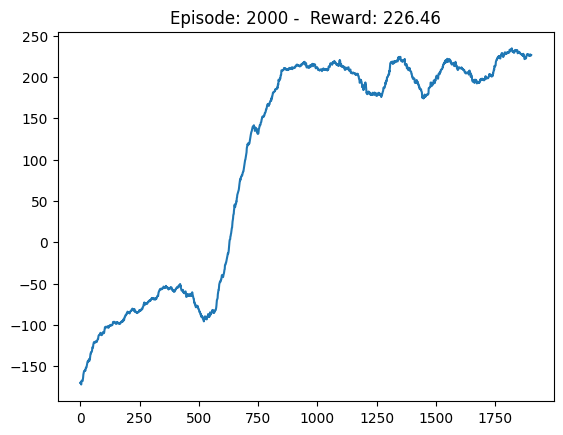

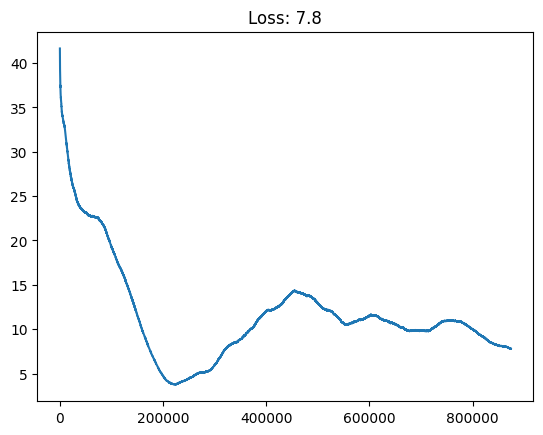

In [27]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

# Hyperparámetros
num_episodes = 2000
epsilon = 1.0
batch_size = 256
discount = 0.99

train(num_episodes, batch_size, discount, epsilon)

### Evaluación

In [28]:
def eval():
    reward_list = []
    for _ in range(100):
        state = env.reset()[0] #reseteo del ecosistema
        ep_reward, done, truncated = 0, False, False
        while not done and not truncated:
            state_in = torch.tensor(state).unsqueeze(0)
            action = select_epsilon_greedy_action(state_in, 0)
            next_state, reward, done, truncated = env.step(action)[:-1]
            ep_reward += reward
            state = next_state
        reward_list.append(ep_reward)
    
    mean = np.mean(reward_list)
    std = np.std(reward_list)
    success_rate = len([x for x in reward_list if x > 200])/len(reward_list)
    print(mean, std, success_rate)

In [44]:
eval()

218.19411653743947 68.09695768008402 0.84


# DoubleDQN

### Modelos

In [45]:
class DoubleDQN(torch.nn.Module):
    """Perceptron multicapa de 2 capas de 32 y una se salida"""
    def __init__(self):
        super(DoubleDQN, self).__init__()
        self.dense1 = nn.Linear(8, 32)
        self.dense2 = nn.Linear(32, 32)
        self.dense3 = nn.Linear(32, 4)

    def forward(self, x):
        """Construcción de las capas"""
        x = self.dense1(x)
        x = F.relu(x)
        x = self.dense2(x)
        x = F.relu(x)
        x = self.dense3(x)
        return x

main_nn = DoubleDQN().to(device) # Red principal
target_nn = DoubleDQN().to(device) # Red objetivo
# Copiamos los pesos de la red principal a la red objetivo
target_nn.load_state_dict(main_nn.state_dict())
# no grad for target_nn
for param in target_nn.parameters():
    param.requires_grad = False

optimizer = optim.AdamW(main_nn.parameters(), lr=1e-4) # Optimizador Adam
mse = nn.MSELoss()

### Funciones (cambios respecto a DQN)

In [46]:
def train_step(states, actions, rewards, next_states, dones, discount, num_actions):
    # Selección de la proxima mejor acción con main_nn.
    next_states = torch.tensor(next_states).to(device)
    next_qs_main = main_nn(next_states)
    argmax_next_qs = torch.argmax(next_qs_main, dim=-1)
    
    # Evaluamos la mejor acción con target_nn para sacar el Q-value.
    next_qs_target = target_nn(next_states)
    argmax_next_qs_masks = F.one_hot(argmax_next_qs, num_actions)
    masked_next_qs_main = torch.sum(argmax_next_qs_masks * next_qs_target, dim=-1)
    
    # Creamos el objetivo usando la recompensa y el descuento del proximo Q-value.
    target = torch.tensor(rewards).to(device) + torch.tensor((1. - dones) * discount).to(device) * masked_next_qs_main
     # Forward pass
    qs = main_nn(torch.tensor(states).to(device))
    action_masks = F.one_hot(torch.tensor(actions).to(device), num_actions)
    masked_qs = torch.sum(action_masks * qs, dim=-1)

    loss = mse(masked_qs, target)
    optimizer.zero_grad()  # Zero gradients
    loss.backward()        # Compute gradients
    optimizer.step()       # Update weights
    return loss

### Entrenamiento

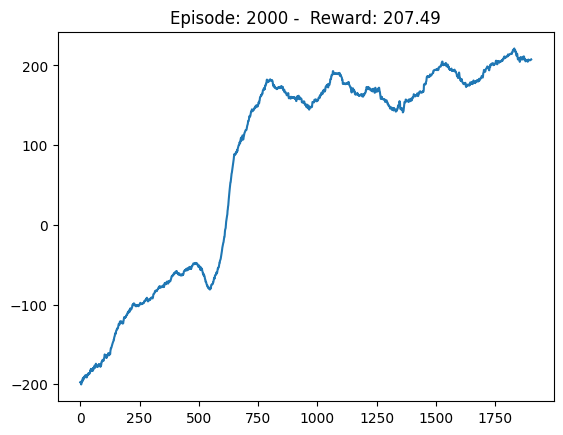

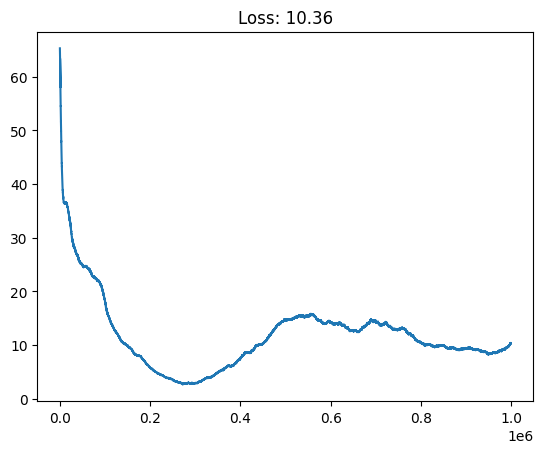

In [30]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

# Hyperparámetros
num_episodes = 2000
epsilon = 1.0
batch_size = 128
discount = 0.99

train(num_episodes, batch_size, discount, epsilon)

### Evaluación

In [55]:
eval()

189.18368573090163 89.97817296143322 0.56


# Dueling DQN

### Modelo

In [36]:
class DuelingDQN(torch.nn.Module):
    """Perceptron multicapa de 2 capas de 32 y una se salida"""
    def __init__(self):
        super(DuelingDQN, self).__init__()
        self.dense1 = nn.Linear(8, 32)
        self.dense2 = nn.Linear(32, 32)
        self.dense_V = nn.Linear(32, 1)
        self.dense_A = nn.Linear(32, 4)

    def forward(self, x):
        """Construcción de las capas"""
        x = self.dense1(x)
        x = F.relu(x)
        x = self.dense2(x)
        x = F.relu(x)
        V = self.dense_V(x)
        A = self.dense_A(x)
        Q = V + (A - torch.mean(A, dim=-1, keepdim=True))
        return Q

main_nn = DuelingDQN().to(device) # Red principal
target_nn = DuelingDQN().to(device) # Red objetivo
# Copiamos los pesos de la red principal a la red objetivo
target_nn.load_state_dict(main_nn.state_dict())
# no grad for target_nn
for param in target_nn.parameters():
    param.requires_grad = False

optimizer = optim.AdamW(main_nn.parameters(), lr=1e-4) # Optimizador Adam
mse = nn.MSELoss()

### Entrenamiento

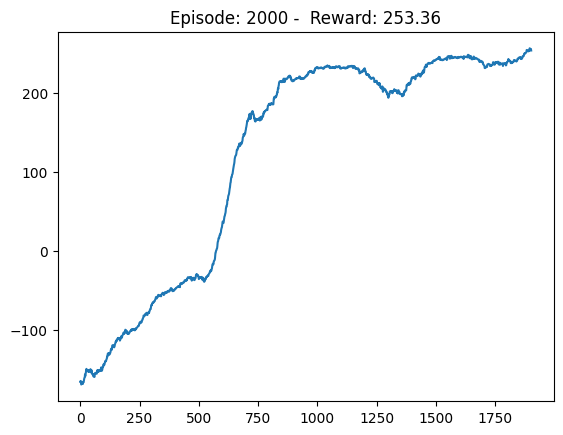

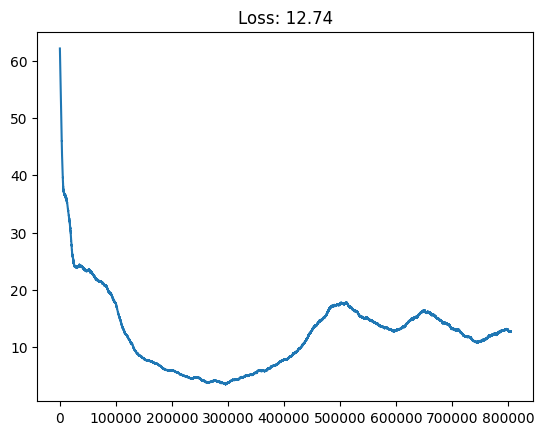

In [32]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

# Hyperparámetros
num_episodes = 2000
epsilon = 1.0
batch_size = 128
discount = 0.99

train(num_episodes, batch_size, discount, epsilon)

### Evaluación

In [38]:
eval()

247.32763293914672 43.010682735991494 0.96


### Comentarios

Todas las versiones de DQN implementadas funcionan de una forma similar y los resultados obtenidos son extremadamente parecidos. Para este problema en particular, no apreciamos las mejoras de Doble y de Dueling, aunque sí es cierto que con Dueling DQN la evolución del reward es algo más suave y estable

# Actor Critic

### Versión diapositivas

In [22]:
class ActorCritic(torch.nn.Module):
    """Perceptron multicapa de 2 capas de 32 y una se salida"""
    def __init__(self):
        super(ActorCritic, self).__init__()
        self.dense1 = nn.Linear(8, 128)
        self.dense_V = nn.Linear(128, 1)
        self.dense_A = nn.Linear(128, 4)
        self.critic = []
        self.actor = []
        self.value_next = []

    def forward(self, x, next=False):
        """Construcción de las capas"""
        x = self.dense1(x)
        x = F.relu(x)
        if next:
            self.value_next.append(self.dense_V(x))
        else:
            self.critic.append(self.dense_V(x))
            self.actor.append(F.softmax(self.dense_A(x), dim=-1))
        return None
    
    def reset(self):
        self.critic = []
        self.actor = []
        self.value_next = []

main_nn = ActorCritic().to(device) # Red principal

optimizer = optim.AdamW(main_nn.parameters(), lr=1e-4) # Optimizador Adam
mse = nn.MSELoss()

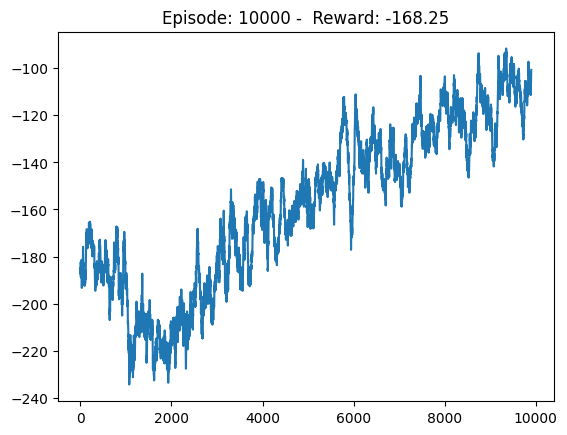

In [12]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

# Hyperparámetros
num_episodes = 10000
discount = 0.99
env = gym.make("LunarLander-v2", render_mode=None)

# Comienzo del entrenamiento. Jugamos una vez y entrenamos con un batch.
reward_list = []
for episode in range(num_episodes+1):
    state = env.reset()[0] #reseteo del ecosistema
    ep_reward, done = 0, False
    num_steps = 0
    rewards = []
    actions = []
    main_nn.reset()
    while not done:
        state_in = torch.tensor(state).unsqueeze(0).to(device)
        main_nn(state_in)
        
        policy = main_nn.actor[-1].squeeze(0)
        action = torch.multinomial(policy, 1).item()
        actions.append(action)
        next_state, reward, done, info = env.step(action)[:-1]
        rewards.append(reward)
        num_steps += 1
        if num_steps > 2000:
            done = True
            ep_reward -= 10
        ep_reward += reward

        # Guardamos el juego.
        next_state_in = torch.tensor(next_state).unsqueeze(0).to(device)
        main_nn(next_state_in, next=True)
        state = next_state

    value = torch.tensor(main_nn.critic).to(device)
    value_next = torch.tensor(main_nn.value_next).to(device)
    policy = main_nn.actor
    advantage = torch.tensor(rewards).to(device) + discount * value_next - value
    loss = 0
    for i in range(len(policy)):
        loss += -torch.log(policy[i].squeeze(0)[actions[i]]) * advantage[i]

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    

    reward_list.append(ep_reward)
    
    if episode % 5 == 0 and len(reward_list) > 100:
        # plot moving average
        clear_output()
        ma_zize = 100
        l = np.convolve(reward_list, np.ones(ma_zize)/ma_zize, mode='valid')
        plt.title('Episode: ' + str(episode) + ' -  Reward: ' + str(ep_reward.round(2)))
        plt.plot(l)
        plt.show()
env.close()

### Comentarios
No hemos conseguido programar una versión funcional a partir del pseudo-código proporcionado en las diapositivas. Parece que el reward va subiendo, pero tarda demasiado en converger

### Implentación alternativa (sacada de internet)

Esta versión hace las cosas de una forma distinta, pero parece que sí obtiene mejores resultados, a pesar de no ser tan buena como los DQNs

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical

class ActorCritic(nn.Module):
    def __init__(self):
        super(ActorCritic, self).__init__()
        self.affine = nn.Linear(8, 128)
        
        self.action_layer = nn.Linear(128, 4)
        self.value_layer = nn.Linear(128, 1)
        
        self.logprobs = []
        self.state_values = []
        self.rewards = []

    def forward(self, state):
        state = torch.from_numpy(state).float()
        state = F.relu(self.affine(state))
        
        state_value = self.value_layer(state)
        
        action_probs = F.softmax(self.action_layer(state))
        action_distribution = Categorical(action_probs)
        action = action_distribution.sample()
        
        self.logprobs.append(action_distribution.log_prob(action))
        self.state_values.append(state_value)
        
        return action.item()
    
    def calculateLoss(self, gamma=0.99):
        
        # calculating discounted rewards:
        rewards = []
        dis_reward = 0
        for reward in self.rewards[::-1]:
            dis_reward = reward + gamma * dis_reward
            rewards.insert(0, dis_reward)
                
        # normalizing the rewards:
        rewards = torch.tensor(rewards)
        rewards = (rewards - rewards.mean()) / (rewards.std())
        
        loss = 0
        for logprob, value, reward in zip(self.logprobs, self.state_values, rewards):
            advantage = reward  - value.item()
            action_loss = -logprob * advantage
            value_loss = F.smooth_l1_loss(value, reward)
            loss += (action_loss + value_loss)   
        return loss
    
    def clearMemory(self):
        del self.logprobs[:]
        del self.state_values[:]
        del self.rewards[:]

In [ ]:
import torch
import torch.optim as optim

reward_list = []
def train():
    # Defaults parameters:
    #    gamma = 0.99
    #    lr = 0.02
    #    betas = (0.9, 0.999)
    #    random_seed = 543

    render = False
    gamma = 0.99
    lr = 0.02
    betas = (0.9, 0.999)
    random_seed = 543
    
    torch.manual_seed(random_seed)
    
    policy = ActorCritic()
    optimizer = optim.Adam(policy.parameters(), lr=lr, betas=betas)
    print(lr,betas)
    
    running_reward = 0
    for i_episode in range(0, 10000):
        state = env.reset()[0]
        for t in range(10000):
            action = policy(state)
            state, reward, done, _ = env.step(action)[:-1]
            policy.rewards.append(reward)
            running_reward += reward
            if render and i_episode > 1000:
                env.render()
            if done:
                break
                    
        # Updating the policy :
        optimizer.zero_grad()
        loss = policy.calculateLoss(gamma)
        loss.backward()
        optimizer.step()        
        policy.clearMemory()
        
        # saving the model if episodes > 999 OR avg reward > 200 
        #if i_episode > 999:
        #    torch.save(policy.state_dict(), './preTrained/LunarLander_{}_{}_{}.pth'.format(lr, betas[0], betas[1]))
        
        if i_episode % 10 == 0:
            running_reward = running_reward/10
            reward_list.append(running_reward)
            print('Episode {}\tlength: {}\treward: {}'.format(i_episode, t, running_reward))
            running_reward = 0

train()
plt.plot(reward_list)

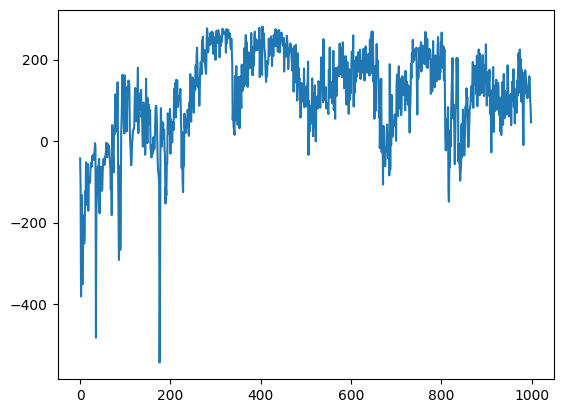

In [9]:
import matplotlib.pyplot as plt
plt.plot(reward_list)